# Analysis of Benchmarking results in R

In [10]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(dplyr)
    library(data.table)
    library(bench)
})

In [11]:
# load and rowbind all benchmarking data
files <- list.files("results", pattern = "\\.csv$", full.names = TRUE)
all_data <- lapply(files, function(file) {
    fread(file, data.table = FALSE) %>%
        mutate(tool = tools::file_path_sans_ext(basename(file)))
}) %>%
    bind_rows() %>%
    relocate(tool) %>%
    mutate(tool = as.factor(tool), mem_alloc = as_bench_bytes(mem_alloc)) %>%
    mutate(across(where(is.character), bench::as_bench_time))

print(levels(all_data$tool))
print(dim(all_data))

[1] "immunarch"     "scRepertoire1" "scRepertoire2"


[1] 25 22


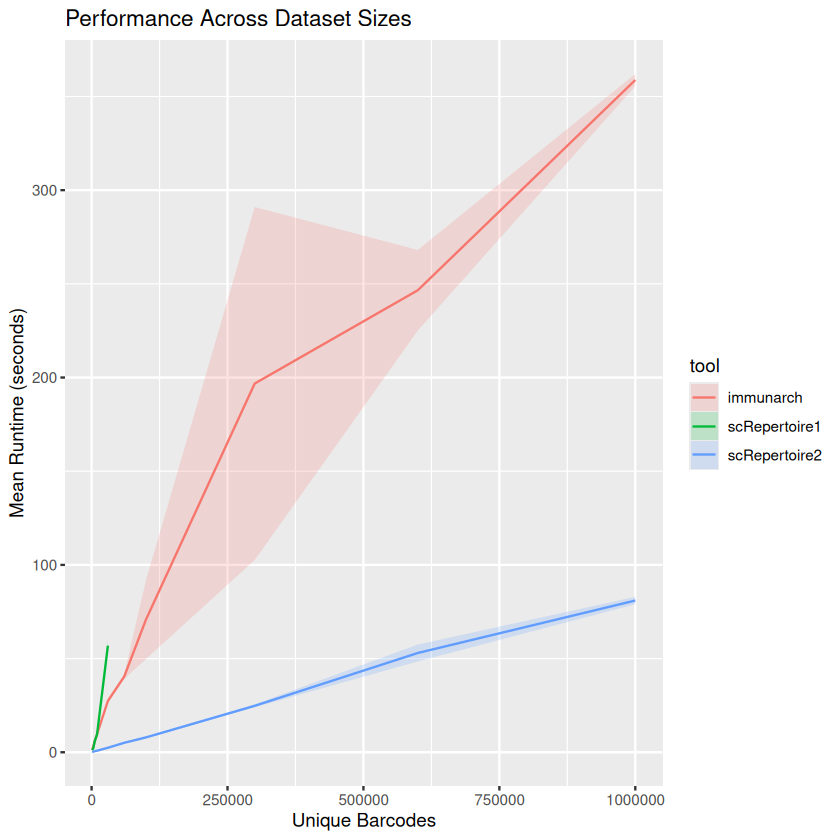

In [12]:
ggplot(all_data, aes(x = dataset_size, y = mean, color = tool, fill = tool)) +
  geom_line() +
  geom_ribbon(aes(ymin = mean - ci95, ymax = mean + ci95), alpha = 0.2, color = NA) +
  labs(x = "Unique Barcodes", y = "Mean Runtime (seconds)", title = "Performance Across Dataset Sizes") +
  scale_y_continuous(trans = "identity")

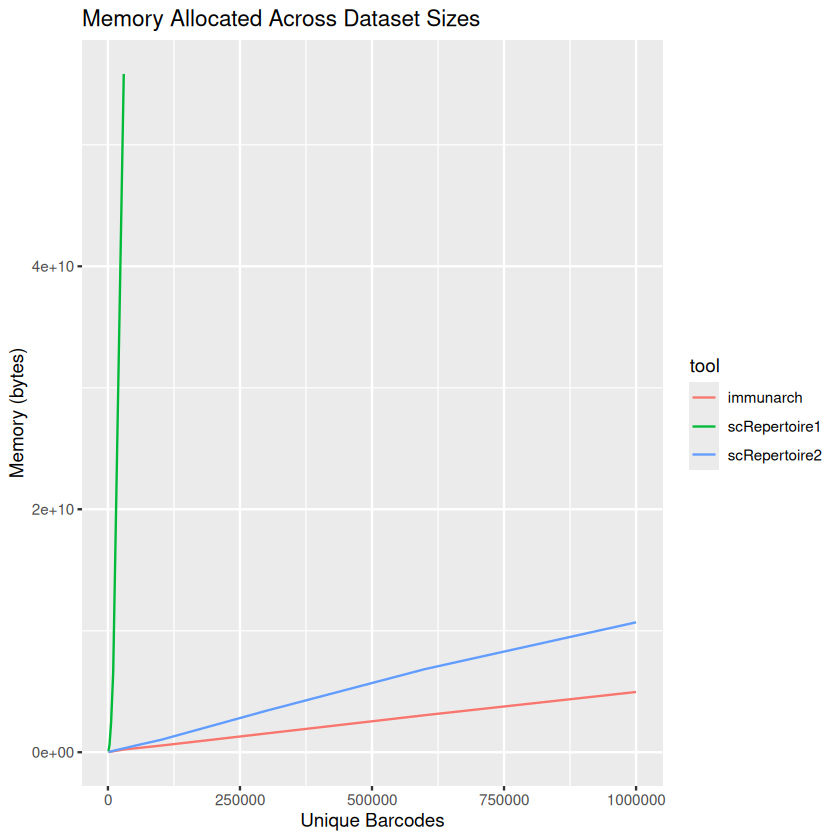

In [19]:
ggplot(all_data, aes(x = dataset_size, y = mem_alloc, color = tool, fill = tool)) +
  geom_line() +
  labs(x = "Unique Barcodes", y = "Memory (bytes)", title = "Memory Allocated Across Dataset Sizes") +
  scale_y_continuous(trans = "identity")

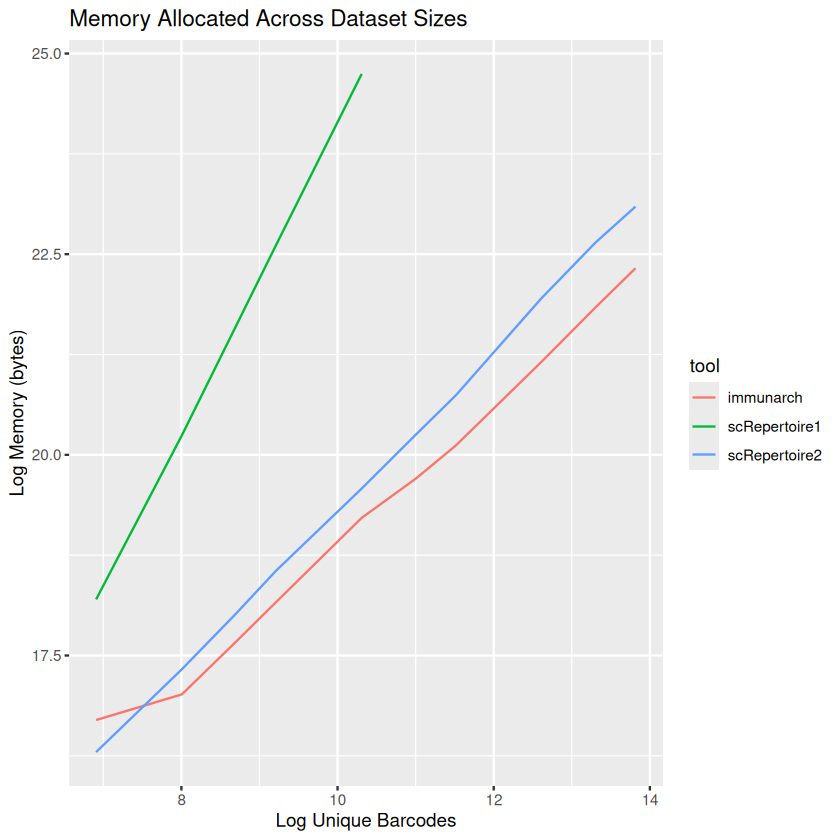

In [20]:
ggplot(all_data, aes(x = log(dataset_size), y = log(mem_alloc), color = tool, fill = tool)) +
  geom_line() +
  labs(x = "Log Unique Barcodes", y = "Log Memory (bytes)", title = "Memory Allocated Across Dataset Sizes") +
  scale_y_continuous(trans = "identity")